# Simulate a single VLE point using GEMC in GOMC

This notebook covers building, simulating, and analyzing a GOMC GEMC simulation

# Build

In [ ]:
import unyt as u

from mosdef_trappe.driver import build
from mosdef_trappe.molecules.ethane.ethane import Ethane
import mosdef_trappe.gomc_util.gomc_functions as gomc_functions


temperature = 236 * u.Kelvin
rho_vap = 0.02*u.g/u.cm**3
rho_liq = 0.469*u.g/u.cm**3
n_compounds = 5000

cmpd = Ethane()
vapor_box = build(cmpd, n_compounds=n_compounds, density=rho_vap,
                 ff='ff/TraPPE_UA_2_fully_flexible_ethane.xml')
liquid_box = build(cmpd, n_compounds=n_compounds, density=rho_liq,
              ff='ff/TraPPE_UA_2_fully_flexible_ethane.xml')

# Simulate

In [ ]:
p = gomc_functions.simulate(vapor_box, liquid_box,
        temperature=temperature,
        n_steps=5000000)

# Analyze


In [1]:
import json
import numpy as np
import unyt as u
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import mosdef_trappe.gomc_util.gomc_functions as gomc_functions

statepoint = json.load(open('pre-computed/statepoint.json','r'))
statepoint['rho_vap'] *= u.kg/u.m**3
statepoint['rho_liq'] *= u.kg/u.m**3
statepoint['temp'] *= u.Kelvin
statepoint['P_vap'] *= u.kilopascal

vapor_df = gomc_functions.dat_to_df('pre-computed/Blk_output_BOX_0.dat')
liquid_df = gomc_functions.dat_to_df('pre-computed/Blk_output_BOX_1.dat')
for i in range(1,10):
    temp_vapor_df = gomc_functions.dat_to_df('pre-computed/Blk_restart{}_BOX_0.dat'.format(i))
    temp_liquid_df = gomc_functions.dat_to_df('pre-computed/Blk_restart{}_BOX_1.dat'.format(i))
    temp_vapor_df['#STEPS'] += vapor_df.iloc[-1]['#STEPS']
    temp_liquid_df['#STEPS'] += liquid_df.iloc[-1]['#STEPS']
    
    vapor_df = vapor_df.append(temp_vapor_df)
    liquid_df = liquid_df.append(temp_liquid_df)

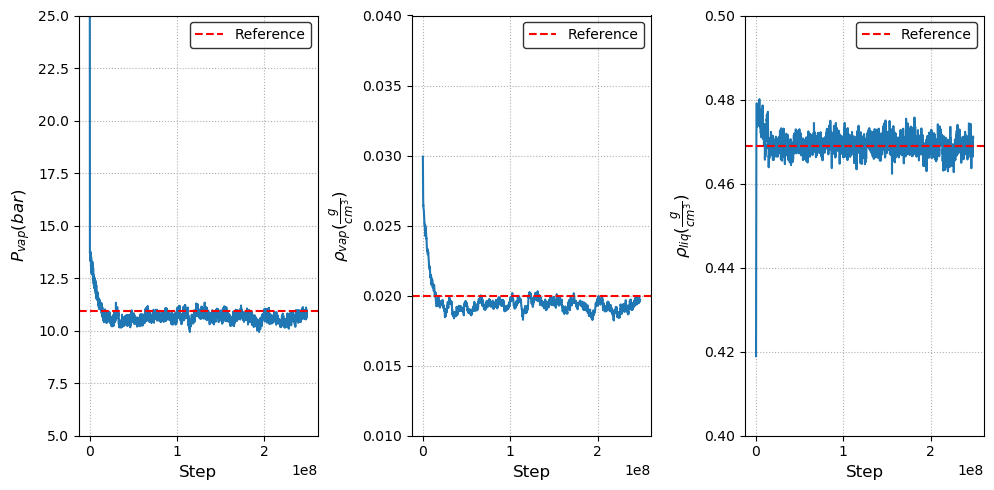

In [2]:
with matplotlib.rc_context(fname='pre-computed/matplotlibrc'):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    ax[0].plot(vapor_df['#STEPS'], vapor_df['PRESSURE'])
    ax[0].axhline(statepoint['P_vap'].in_units(u.bar).value, label='Reference',
                 color='red', linestyle='--')
    ax[0].set_ylabel(r"$P_{vap}(bar)$")
    ax[0].set_xlabel("Step")
    ax[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax[0].set_ylim([5, 25])
    ax[0].legend()

    ax[1].plot(vapor_df['#STEPS'], vapor_df['TOT_DENS'])
    ax[1].axhline(statepoint['rho_vap'].in_units(u.g/u.cm**3).value, label='Reference',
                 color='red', linestyle='--')
    ax[1].set_ylabel(r"$\rho_{vap} (\frac{g}{cm^3})$")
    ax[1].set_xlabel("Step")
    ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax[1].set_ylim([0.01,0.04])
    ax[1].legend()

    ax[2].plot(liquid_df['#STEPS'], liquid_df['TOT_DENS'])
    ax[2].axhline(statepoint['rho_liq'].in_units(u.g/u.cm**3).value, label='Reference',
                 color='red', linestyle='--')
    ax[2].set_ylabel(r"$\rho_{liq} (\frac{g}{cm^3})$")
    ax[2].set_xlabel("Step")
    ax[2].ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax[2].set_ylim([0.4, 0.5])
    ax[2].legend()

    plt.tight_layout()
    fig.savefig('pre-computed/vle_plots.pdf')